#Импорты

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.8 MB/s 
     |████████████████████████████████| 482 kB 57.2 MB/s 
     |████████████████████████████████| 462 kB 39.6 MB/s 
     |████████████████████████████████| 41 kB 225 kB/s 


In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=2f429fbf2e35a8f884826a007eab2f8349cbadf703a72a299e6127434b1e1abd
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [4]:
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from gensim.models import Word2Vec
from stellargraph.data import BiasedRandomWalk
import networkx as nx
import multiprocessing

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import sys
sys.path.append('/content/gdrive/My Drive')

#История про данные

Скопировать с курсовой 

Может взять новый датасет с майанимелист?

# Данные в виде графа

In [8]:
anime = pd.read_csv('/content/gdrive/My Drive/anime.csv')
print(anime.columns)

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')


In [9]:
rating = pd.read_csv('/content/gdrive/My Drive/rating.csv')
print(rating.columns)

Index(['user_id', 'anime_id', 'rating'], dtype='object')


Оставим понравившееся

In [10]:
rating_liked = rating.drop(rating[rating['rating'].values < 5].index).drop(columns='rating')
rating_liked

,user_id,anime_id
47,1,8074
81,1,11617
83,1,11757
101,1,15451
153,2,11771
...,...,...
7813732,73515,16512
7813733,73515,17187
7813734,73515,22145
7813735,73516,790


Теперь нужно построить граф типа сор-таргет-веса для отправления в машинку по созданию графов

In [11]:
similar_users = rating_liked[rating_liked.duplicated('anime_id', keep=False)].groupby('anime_id')['user_id'].apply(list).reset_index()
print(similar_users)

      anime_id                                            user_id
0            1  [19, 21, 23, 32, 34, 43, 46, 50, 51, 55, 68, 7...
1            5  [19, 21, 23, 51, 139, 152, 160, 200, 234, 242,...
2            6  [5, 17, 32, 41, 51, 55, 81, 97, 103, 108, 109,...
3            7  [160, 177, 277, 352, 646, 814, 1039, 1089, 117...
4            8  [296, 2515, 2812, 3127, 4738, 4749, 4930, 5016...
...        ...                                                ...
8739     34324  [3009, 13337, 13954, 22839, 31035, 40474, 4126...
8740     34325  [1734, 10194, 22835, 33519, 33915, 35370, 4241...
8741     34349                              [22434, 38503, 57620]
8742     34367                              [30565, 47765, 59643]
8743     34475                              [13954, 53492, 70547]

[8744 rows x 2 columns]


In [12]:
anime = anime.dropna()

In [13]:
for_merging = anime[['anime_id', 'name', 'type','genre']]
for_merging['attr'] = for_merging['name'] + ' '+ for_merging['type'] + ' ' + for_merging['genre']
for_merging = for_merging.drop(['name', 'type','genre'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
for_merging

,anime_id,attr
0,32281,"Kimi no Na wa. Movie Drama, Romance, School, S..."
1,5114,"Fullmetal Alchemist: Brotherhood TV Action, Ad..."
2,28977,"Gintama° TV Action, Comedy, Historical, Parody..."
3,9253,"Steins;Gate TV Sci-Fi, Thriller"
4,9969,"Gintama&#039; TV Action, Comedy, Historical, P..."
...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami O...
12290,5543,Under World OVA Hentai
12291,5621,Violence Gekiga David no Hoshi OVA Hentai
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...


In [15]:
similar_users = similar_users.merge(for_merging, 
                        on=['anime_id'],
                        how='inner')
similar_users

,anime_id,user_id,attr
0,1,"[19, 21, 23, 32, 34, 43, 46, 50, 51, 55, 68, 7...","Cowboy Bebop TV Action, Adventure, Comedy, Dra..."
1,5,"[19, 21, 23, 51, 139, 152, 160, 200, 234, 242,...","Cowboy Bebop: Tengoku no Tobira Movie Action, ..."
2,6,"[5, 17, 32, 41, 51, 55, 81, 97, 103, 108, 109,...","Trigun TV Action, Comedy, Sci-Fi"
3,7,"[160, 177, 277, 352, 646, 814, 1039, 1089, 117...","Witch Hunter Robin TV Action, Drama, Magic, My..."
4,8,"[296, 2515, 2812, 3127, 4738, 4749, 4930, 5016...","Beet the Vandel Buster TV Adventure, Fantasy, ..."
...,...,...,...
8728,34324,"[3009, 13337, 13954, 22839, 31035, 40474, 4126...",Chiryokumaru ONA Action
8729,34325,"[1734, 10194, 22835, 33519, 33915, 35370, 4241...","Pokemon XY&amp;Z Specials Special Action, Adve..."
8730,34349,"[22434, 38503, 57620]","Diamond no Ace: Second Season OVA OVA Comedy, ..."
8731,34367,"[30565, 47765, 59643]","Long Riders Recap Special Comedy, Shounen, Sli..."


Сериал сравнивается с остальными сериалами (сразу в цикле пропускать нули сделать) по количеству общих пользователей - эти общие пользователи и есть веса

In [16]:
graph = pd.DataFrame(data=similar_users).sample(n=800).reset_index().drop(columns=['index'])

In [16]:
# for_graph_weighted = {}

In [19]:
# k = 0
# for i in range(1, 800):
#   current_value = set(graph[graph.index == int(i-1)]['user_id'].values[0])
#   for j in range(i, 800):
#     compare_value = set(graph[graph.index == j]['user_id'].values[0])
#     weight = len(current_value & compare_value)
#     for_graph_weighted[k] = {'source': graph[graph.index == int(i-1)]['attr'].values[0], 'target': graph[graph.index == j]['attr'].values[0], 'weight': weight}
#     k += 1

In [ ]:
# data = pd.DataFrame.from_dict(for_graph_weighted).T
# data = data.drop(data[data['weight'] == 0].index)
# data['source'] = data['source'].astype(str)
# data['target'] = data['target'].astype(str)
# data['weight'] = data['weight'].astype(int)

In [ ]:
# compression_opts = dict(method='zip', archive_name='randsamp800.csv')
# data.to_csv('randsamp800.zip', index=False, compression=compression_opts)

In [18]:
data = pd.read_csv('/content/randsamp800.csv')

Теперь разредим граф, отбросив веса меньше 50 пользователей

In [19]:
data.shape

(194393, 3)

In [20]:
data_fin = data.drop(data[data['weight'] <= 50].index)

In [21]:
data_fin.shape

(20771, 3)

Сохраним названия сериалов, которые оказались в финальном датасете

In [22]:
names_available = data_fin['source'].unique()

Создадим два одинаковых графа с помощью двух инструментов и посмотрим на них.

In [23]:
graph_sg = StellarGraph(edges=data_fin, node_type_default="anime", edge_type_default="nusers_shared")

In [24]:
graph_nx = nx.from_pandas_edgelist(data_fin, 'source', 'target', 'weight')

In [25]:
print(graph_sg.info())

StellarGraph: Undirected multigraph
 Nodes: 399, Edges: 20771

 Node types:
  anime: [399]
    Features: none
    Edge types: anime-nusers_shared->anime

 Edge types:
    anime-nusers_shared->anime: [20771]
        Weights: range=[51, 12320], mean=246.678, std=443.671
        Features: none


In [26]:
print(nx.info(graph_nx))

Graph with 399 nodes and 20771 edges


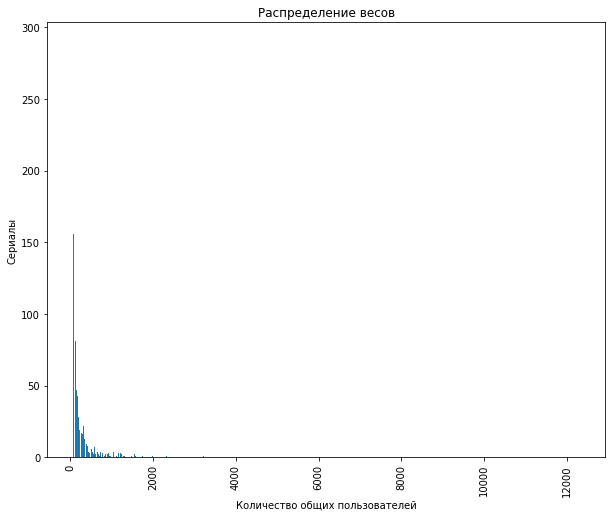

In [28]:
names, weights = graph_sg.edges(include_edge_weight=True)

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt)
plt.title("Распределение весов")
plt.ylabel("Сериалы")
plt.xlabel("Количество общих пользователей")
plt.xticks(rotation=90)

plt.show()

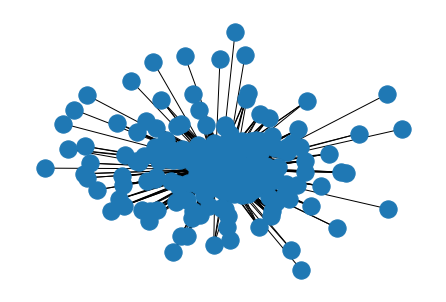

In [29]:
nx.draw(graph_nx)

# Train Test (оставить пока)

## StellarGraph

In [30]:
edge_splitter_test_sg = EdgeSplitter(graph_sg)
graph_test_sg, examples_test_sg, labels_test_sg = edge_splitter_test_sg.train_test_split(p=0.01, method="global")
print(graph_test_sg.info())

** Sampled 207 positive and 207 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 399, Edges: 20564

 Node types:
  anime: [399]
    Features: none
    Edge types: anime-nusers_shared->anime

 Edge types:
    anime-nusers_shared->anime: [20564]
        Weights: range=[51, 12320], mean=246.695, std=443.766
        Features: none


In [31]:
edge_splitter_train_sg = EdgeSplitter(graph_test_sg, graph_sg)
graph_train_sg, examples_sg, labels_sg = edge_splitter_train_sg.train_test_split(p=0.01, method="global")
examples_train_sg, examples_model_selection_sg, labels_train_sg, labels_model_selection_sg = train_test_split(examples_sg, labels_sg, train_size=0.75, test_size=0.25)

print(graph_train_sg.info())

** Sampled 205 positive and 205 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 399, Edges: 20359

 Node types:
  anime: [399]
    Features: none
    Edge types: anime-nusers_shared->anime

 Edge types:
    anime-nusers_shared->anime: [20359]
        Weights: range=[51, 12320], mean=246.52, std=443.625
        Features: none


In [32]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train_sg),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection_sg),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test_sg),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,307,Train Graph,Test Graph,Train the Link Classifier
Model Selection,103,Train Graph,Test Graph,Select the best Link Classifier model
Test set,414,Test Graph,Full Graph,Evaluate the best Link Classifier


In [ ]:
# for_test = pd.DataFrame(data=similar_users)[-200:]
# for_graph_weighted = {}
# k = 0
# for i in range(8534, 8733):
#   current_value = set(for_test[for_test.index == int(i-1)]['user_id'].values[0])
#   for j in range(i, 8733):
#     compare_value = set(for_test[for_test.index == j]['user_id'].values[0])
#     weight = len(current_value & compare_value)
#     for_graph_weighted[k] = {'source': for_test[for_test.index == int(i-1)]['attr'].values[0], 'target': for_test[for_test.index == j]['attr'].values[0], 'weight': weight}
#     k += 1

# data_test = pd.DataFrame.from_dict(for_graph_weighted).T
# data_test = data_test.drop(data_test[data_test['weight'] == 0].index)
# data_test['source'] = data_test['source'].astype(str)
# data_test['target'] = data_test['target'].astype(str)
# data_test['weight'] = data_test['weight'].astype(int)

# graph_nx_test = nx.from_pandas_edgelist(data_test, 'source', 'target', 'weight')

## NetworkX

https://stackoverflow.com/questions/53255889/test-train-data-set-for-graph-network

In [73]:
edge_splitter_test_nx = EdgeSplitter(graph_nx)
graph_test_nx, examples_test_nx, labels_test_nx = edge_splitter_test_nx.train_test_split(p=0.01, method="global")

print(nx.info(graph_test_nx))

** Sampled 207 positive and 207 negative edges. **
Graph with 399 nodes and 20564 edges


In [74]:
edge_splitter_train_nx = EdgeSplitter(graph_test_nx, graph_nx)
graph_train_nx, examples_nx, labels_nx = edge_splitter_train_nx.train_test_split(p=0.01, method="global")
examples_train_nx, examples_model_selection_nx, labels_train_nx, labels_model_selection_nx = train_test_split(examples_nx, labels_nx, train_size=0.75, test_size=0.25)

print(nx.info(graph_train_nx))

** Sampled 205 positive and 205 negative edges. **
Graph with 399 nodes and 20359 edges


In [75]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train_nx),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection_nx),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test_nx),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,307,Train Graph,Test Graph,Train the Link Classifier
Model Selection,103,Train Graph,Test Graph,Select the best Link Classifier model
Test set,414,Test Graph,Full Graph,Evaluate the best Link Classifier


# Эмбеддинги

## word2vec и stellargraph

Можно поделать нод2век со стеллариграфом, через ворд2век

In [36]:
rw = BiasedRandomWalk(graph_train_sg)
weighted_walks = rw.run(
    nodes=graph_train_sg.nodes(),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 3990


In [37]:
weighted_model = Word2Vec(weighted_walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1)
weighted_node_embeddings = weighted_model.wv.vectors

Нарисуем с помощью T-SNE

In [38]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


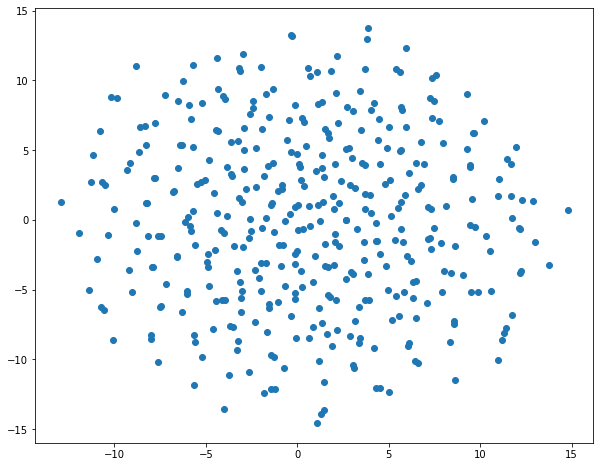

In [39]:
plt.figure(figsize=(10, 8))
plt.scatter(weighted_node_embeddings_2d[:, 0], weighted_node_embeddings_2d[:, 1])
plt.show()

In [40]:
for node, score in weighted_model.wv.most_similar('Sonic X TV Adventure, Comedy, Kids, Mecha, Sci-Fi, Shounen'):
  print(node, score)

Mobile Suit Zeta Gundam: A New Translation III - Love Is the Pulse of the Stars Movie Drama, Mecha, Military, Sci-Fi, Space 0.22597163915634155
Zettai Karen Children TV Action, Comedy, Shounen, Supernatural 0.21202607452869415
Recorder to Randoseru Re♪ TV Comedy, School, Seinen, Slice of Life 0.2100255936384201
Flanders no Inu (Movie) Movie Drama, Historical 0.19356366991996765
Hanaukyou Maid-tai TV Comedy, Ecchi, Harem, Romance 0.1927463412284851
Taiho Shichau zo in America Special Action, Comedy, Police, Shounen 0.19127406179904938
Dakara Boku wa, H ga Dekinai. Recap Special Comedy, Ecchi, Romance, Supernatural 0.17660650610923767
Suisei no Gargantia TV Action, Adventure, Mecha, Sci-Fi 0.17443501949310303
Yoroiden Samurai Troopers TV Adventure, Samurai, Sci-Fi, Shounen 0.170066237449646
Bakuten Shoot Beyblade TV Action, Adventure, Comedy, Sci-Fi, Shounen, Sports 0.16426245868206024


## Теперь нод2век

In [41]:
node2vec = Node2Vec(graph_train_nx, dimensions=20, walk_length=16, num_walks=10, weight_key='weight')
model = node2vec.fit(window=3, min_count=1)

Computing transition probabilities:   0%|          | 0/399 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


In [42]:
ne = model.wv.vectors
tsne2 = TSNE(n_components=2, random_state=42)
ne_2d = tsne2.fit_transform(ne)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [43]:
ne.shape

(399, 20)

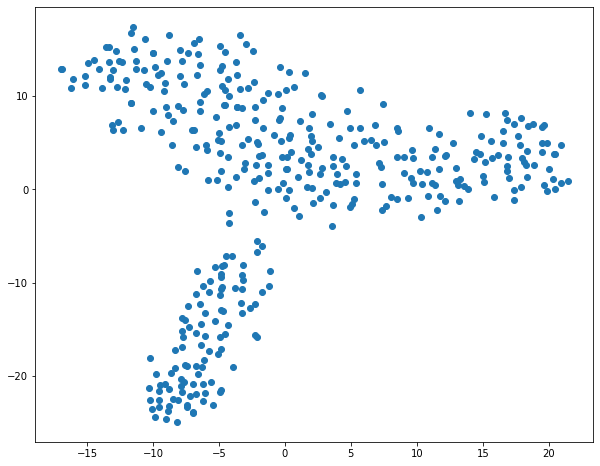

In [44]:
plt.figure(figsize=(10, 8))
plt.scatter(ne_2d[:, 0], ne_2d[:, 1])
plt.show()

In [100]:
print(names_available[0], model.wv.get_vector(names_available[0]))

Mugen no Ryvius TV Drama, Mecha, Military, Psychological, Sci-Fi, Space [-0.42234614 -0.38862103  0.18610914  0.25497583  0.03127626 -0.66185516
  0.10134229 -0.51533127 -0.05430074 -0.16984874 -0.0638697  -0.14211889
  0.1193101   0.32395002  0.37024298 -0.1071046  -0.15875523 -0.22284387
 -0.31161615 -0.08422556]


In [46]:
for node, score in model.wv.most_similar('Sonic X TV Adventure, Comedy, Kids, Mecha, Sci-Fi, Shounen'):
  print(node, score)

Kämpfer Picture Drama Special Comedy 0.9981759190559387
Yume-iro Pâtissière: Mune Kyun Tropical Island! Special Kids, School, Shoujo 0.9978561997413635
Kuroinu: Kedakaki Seijo wa Hakudaku ni Somaru OVA Action, Fantasy, Hentai 0.9978333115577698
Osakana wa Ami no Naka OVA Drama, Shounen Ai 0.9977458715438843
Dual Parallel! Trouble Adventures Special Special Comedy, Drama, Harem, Mecha, Romance, Sci-Fi 0.9977285861968994
Kagaku Ninja-tai Gatchaman TV Action, Adventure, Sci-Fi, Shounen 0.9976598024368286
Code Geass: Hangyaku no Lelouch R2 Special Edition Zero Requiem OVA Action, Mecha, Military, Super Power 0.9975928664207458
Devilman: Yochou Sirene-hen OVA Demons, Horror, Sci-Fi, Supernatural 0.9975897669792175
Taiho Shichau zo in America Special Action, Comedy, Police, Shounen 0.9975740909576416
One Piece: Episode of Alabasta - Prologue OVA Action, Adventure, Fantasy, Shounen 0.9975407719612122


# Классификация

Теперь вектора преобразуем, попробуем 4 метода (все они описаны в статье Лесковца про нод2век), сделаем классификацию и посмотрим с каким преобразованием рок-аук лучше выйдет

In [101]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0

In [104]:
def get_vectorized(link_features):
  s = []
  d = []
  for src, dst in link_features:
    s.append(model.wv[src])
    d.append(model.wv[dst])
  return np.array(s), np.array(d)

In [105]:
def apply_operator(s, d, op):
  transformed = op(s, d)
  return transformed

In [112]:
def do_classification(f_train, l_train, op):
  s, d = get_vectorized(f_train)
  X_train = op(s, d)
  y_train = l_train

  lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=1000)
  pipa = Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])
  pipa.fit(X_train, y_train)

  return pipa

In [107]:
def evaluate(classif, f_test, l_test, op):
  s_test, d_test = get_vectorized(f_test)
  testing_labels = apply_operator(s_test, d_test, op)
  predicted = classif.predict_proba(testing_labels)
  positive_column = list(classif.classes_).index(1)
  return roc_auc_score(l_test, predicted[:, positive_column])

In [108]:
def run_prediction(op):
  clf = do_classification(examples_train_nx, labels_train_nx, op)
  score = evaluate(clf, examples_model_selection_nx, labels_model_selection_nx, op)
  return {
        "classifier": clf,
        "binary_operator": op,
        "score": score,
    }

# Оценка модели

In [109]:
binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [113]:
results = [run_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_hadamard'


,ROC AUC score
name,
operator_hadamard,0.898715
operator_l1,0.824263
operator_l2,0.808768
operator_avg,0.893424
